# Modelos de regressão linear

Com o objetivo de prever os valores de carros do conjunto de dados, foram utilizados dois modelos de regressão: Lasso Linear Regression e Stochastic Gradient Descent. O problema apresentado é um problema de regressão, uma vez que a variável alvo é contínua e não requer previsão em categorias, como seria o caso de um problema de classificação.

A regressão linear simples utiliza o termo intercept adicionado à soma dos pesos multiplicados por cada uma das variáveis. Por outro lado, o Gradient Descent é um algoritmo de otimização que tem como objetivo reduzir os parâmetros da regressão, minimizando assim a função de custo. Isso é realizado por meio do aprimoramento gradual dos parâmetros até atingir o mínimo global.

A regressão linear regularizada é uma técnica utilizada para evitar o overfitting dos dados, ou seja, evitar que o modelo se ajuste excessivamente aos dados de treinamento e não generalize bem para novos dados.

Na entrega final, foi utilizada uma combinação dos dois modelos para obter previsões mais robustas e precisas.

---


**O script se divide em:**



1.   Carregamento de dados
2.   Pré-processamento
3. Lasso Linear Regression
4. Stochastic Gradient Descent
5. Testes dos modelos e arquivo final
6. Considerações finais



# 1. Carregamento de dados

In [ ]:
# Bibliotecas utilizadas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Seed para que os resultados não se alterem

np.random.seed(42)

# Exibir todas colunas

pd.set_option('display.max_columns', None)

In [ ]:
# Dados de treino e teste

train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projetos/Lighthouse 2/cars_train.csv', encoding='utf-16', sep = "\t", on_bad_lines='skip')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projetos/Lighthouse 2/cars_test.csv', encoding='utf-16', sep = "\t", on_bad_lines='skip')

# 2. Pré-processamento

Nesta etapa, serão realizados os ajustes necessários nas features para que possam ser utilizadas em um algoritmo de regressão linear.

**Retirada de colunas:** Nesta etapa, serão removidas as colunas que não serão utilizadas. As colunas 'veiculo_alienado' e 'id' são irrelevantes para o modelo. Além disso, a coluna 'preco' foi ajustada para estar presente somente nos conjuntos de dados pertinentes.

Os dados de treinamento e teste foram combinados para facilitar o pré-processamento.

In [ ]:
# Retirada de colunas irrelevantes

train_dropped = train.drop(columns=['veiculo_alienado', 'id', 'preco'])
test_dropped = test.drop(columns=['veiculo_alienado', 'id'])
y_s = train['preco']

# Junção de train e test

all_data = pd.concat([train_dropped, test_dropped], axis=0)

print(f'Shape dos dados de treino: {train_dropped.shape}')
print(f'Shape dos dados de teste: {test_dropped.shape}')
print(f'Shape dos df juntos: {all_data.shape}')

Shape dos dados de treino: (29584, 26)
Shape dos dados de teste: (9862, 26)
Shape dos df juntos: (39446, 26)


**Transformação logarítmica da coluna target:** Quando temos uma distribuição enviesada para a esquerda, como é o caso da coluna 'preco', os valores resultantes tendem a ficar em um intervalo pequeno. Além disso, modelos de machine learning geralmente preferem distribuições simétricas. Para contornar essa situação, foi aplicada a transformação logarítmica na coluna 'preco'.

Após a modelagem, a coluna de previsões será revertida para os valores originais por meio da transformação inversa logarítmica.

<Figure size 1200x600 with 0 Axes>

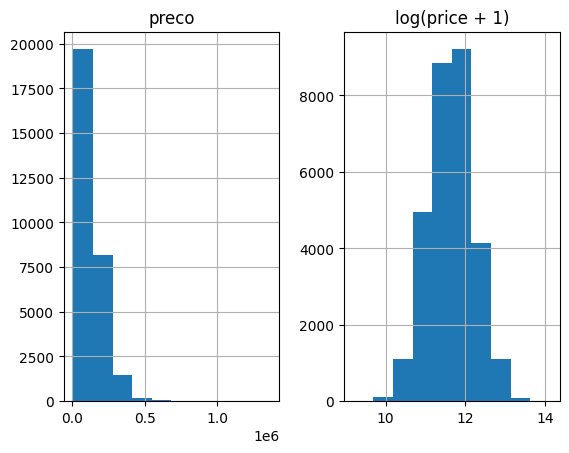

In [ ]:
# Visualização da skew da coluna target

plt.figure(figsize = (12, 6))
precos = pd.DataFrame({"preco":y_s, "log(price + 1)":np.log1p(y_s)})
precos.hist()

# Transformação logarítmica da coluna target

y = np.log1p(y_s)

Os dados deste conjunto de dados são, em sua maioria, categóricos. Portanto, será realizada a conversão dos dados categóricos para representação numérica, como a codificação binária (1 e 0), para que os valores possam ser compreendidos pelo modelo.

In [ ]:
# Transformação de colunas com NaN dos dados de treino

all_data['garantia_de_fábrica'] = all_data['garantia_de_fábrica'].replace({np.nan:0, 'Garantia de fábrica':1})
all_data['revisoes_dentro_agenda'] = all_data['revisoes_dentro_agenda'].replace({np.nan:0, 'Todas as revisões feitas pela agenda do carro':1})
all_data['revisoes_concessionaria'] = all_data['revisoes_concessionaria'].replace({np.nan:0, 'Todas as revisões feitas pela concessionária':1})
all_data['veiculo_único_dono'] = all_data['veiculo_único_dono'].replace({np.nan:0, 'Único dono':1})
all_data['veiculo_licenciado'] = all_data['veiculo_licenciado'].replace({np.nan:0, 'Licenciado':1})
all_data['ipva_pago'] = all_data['ipva_pago'].replace({np.nan:0, 'IPVA pago':1})
all_data['dono_aceita_troca'] = all_data['dono_aceita_troca'].replace({np.nan:0, 'Aceita troca':1})


In [ ]:
# Transformação de colunas True e False dos dados de treino

all_data['entrega_delivery'] = all_data['entrega_delivery'].replace({True:1, False:0})
all_data['troca'] = all_data['troca'].replace({True:1, False:0})
all_data['elegivel_revisao'] = all_data['elegivel_revisao'].replace({True:1, False:0})
all_data['blindado'] = all_data['blindado'].replace({'N':0, 'S':1})

**One Hot Enconding:** Algoritmos de Machine Learning assumem que dois valores próximos um do outro são mais similares do que valores distantes. Essa suposição funciona bem quando temos categorias ordinais, como "bom", "ruim" e "médio". No entanto, nas colunas selecionadas para passar pelo processo de One Hot Encoding, não temos uma ordem específica entre as categorias. Portanto, é necessário atribuir valores diferentes para cada categoria, mas sem criar uma ordem implícita. Nesse caso, uma coluna será transformada em 1 (hot) e as outras em 0 (cold), criando assim atributos dummy.

Esse processo resultará em um conjunto de treinamento com um grande número de features, porém isso será tratado adequadamente pelos modelos utilizados.

In [ ]:
# Aplicando OneHotEnconder() nas colunas apropriadas
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

cols = ['num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'anunciante']
ct = ColumnTransformer(
    [('ohe', OneHotEncoder(), cols)]
)

all_data_ts = ct.fit_transform(all_data).toarray()

O conjunto geral será dividido em conjuntos de treinamento e teste. O tamanho do conjunto de teste será de 30% do total de dados.

In [ ]:
from sklearn.model_selection import train_test_split

# Treino e teste finais

X_train_p = all_data_ts[:29584, :]
X_test_final = all_data_ts[29584:, :]

# Separando os dados em treino e teste

X_train, X_test, y_train, y_test = train_test_split(
    X_train_p, y, test_size = 0.3, random_state=42)

# 3. Lasso Linear Regression

A Lasso Regression é um modelo de regressão regularizada que possui um termo de regularização que inclui um viés, reduzindo a variância do modelo e evitando o overfitting. Esse termo é adicionado à função de custo com o objetivo de alcançar um equilíbrio entre o overfitting e o underfitting do modelo.

Uma das vantagens da Lasso Regression é que ela tende a reduzir os pesos de variáveis menos importantes para o modelo até atingirem zero. Isso automaticamente realiza uma seleção de features, com alguns modelos de pesos iguais a zero e outros com pesos diferentes de zero. Esse processo torna a modelagem mais eficiente em comparação com outros modelos, como a Ridge Regression, que nunca atribui pesos zero às suas variáveis.

A desvantagem da Lasso Regression é sensível à escala das variáveis independentes, pois diferentes escalas podem resultar em efeitos de penalização desiguais. Para contornar essa sensibilidade, neste modelo foi aplicada a padronização dos dados por meio do One-Hot Encoding. Isso ajuda a garantir que todas as variáveis tenham uma escala semelhante e não afetem desproporcionalmente o termo de penalização da Lasso Regression.

In [ ]:
# Lasso Regression

from sklearn.linear_model import LassoCV, LassoLarsCV
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], random_state=42).fit(X_train, y_train)

In [ ]:
# Coeficiente da função Lasso

coef = pd.Series(model_lasso.coef_, index = X_train.dtype.names)

print(f'Lasso selecionou {str(sum(coef != 0))} variáveis e eliminou {str(sum(coef == 0))} variáveis.')

Lasso selecionou 195 variáveis e eliminou 3153 variáveis.


In [ ]:
# Predição

train_pred_lasso = model_lasso.predict(X_test)

**Gráfico de resíduos:** Este gráfico representa a diferença entre os valores de y_teste e y_pred, ou seja, o erro da predição.

Os resíduos estão distribuídos aleatoriamente em torno de zero, o que indica que o modelo está capturando adequadamente a relação entre as features e a variável target. Se houvesse um padrão nos resíduos, por exemplo, uma forma ascendente ou descendente, poderia indicar que o modelo não está capturando corretamente a relação.

Outro fator importante a ser observado para avaliar o desempenho do modelo é a homoscedasticidade, que refere-se à constância da variância dos resíduos em relação aos valores previstos. A forma apresentada indica que o modelo não está violando esse princípio. Se o formato fosse como um funil, isso indicaria que a variância dos resíduos variaria à medida que os valores previstos oscilam, o que poderia levar a estimativas imprecisas.

<Figure size 600x600 with 0 Axes>

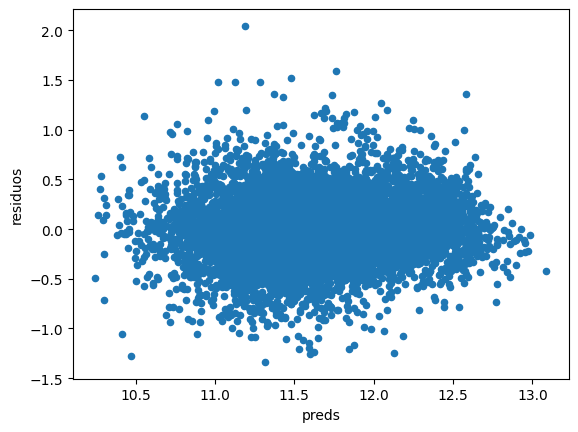

In [ ]:
# Resíduos da função Lasso

plt.figure(figsize= (6.0, 6.0))

preds = pd.DataFrame({"preds":train_pred_lasso, "verdadeiros":y_test})
preds["residuos"] = preds["verdadeiros"] - preds["preds"]
preds.plot(x = "preds", y = "residuos",kind = "scatter")
plt.show()

**RMSE:** A raiz quadrada do erro médio, é uma métrica que mostra a distância média entre os valores previstos pelo modelo e os valores verdadeiros do conjunto de dados. Quanto menor o erro, melhores são os resultados e mais precisas são as previsões.

O RMSE foi escolhido por ser uma boa métrica para ajuste de modelos usando algoritmos baseados em gradientes, como a regressão linear. Além disso, pode ser usado como uma medida padrão para comparar o desempenho de diferentes modelos, como está sendo feito neste projeto, permitindo a avaliação de diferentes abordagens para determinar qual delas produz as melhores previsões.

In [ ]:
# Avaliando o modelo com RMSE

from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, train_pred_lasso))
print('Root mean squared error:', rms)

Root mean squared error: 0.3165571554348022


# 4. Stochastic Gradient Descent

O Stochastic Gradient Descent (SGD) utiliza apenas algumas instâncias do conjunto de treinamento, selecionadas aleatoriamente, para atualizar a função de custo. Ao contrário do Batch Gradient Descent, o SGD não utiliza todas as instâncias do conjunto de dados em cada epoch. Uma epoch representa o número de vezes que o vetor de pesos percorre os passos do modelo, e também determina o critério de parada quando a função de custo atinge uma tolerância específica.

As vantagens do uso do SGD são sua eficiência computacional e o fato de não exigir o uso de todo o conjunto de dados de treinamento em cada iteração. Além disso, o SGD tem maior probabilidade de escapar de mínimos locais devido à sua aleatoriedade, permitindo que alcance mínimos globais.

Uma das desvantagens do SGD está relacionada à sua aleatoriedade. Embora isso possa ajudar a alcançar mínimos globais, se a taxa de aprendizado não estiver adequadamente ajustada, o SGD pode ficar preso em mínimos locais e não alcançar os mínimos globais. Além disso, o SGD pode ter dificuldades em lidar com conjuntos de dados desbalanceados, nos quais a proporção entre as classes é desigual. No entanto, esse não é o caso deste conjunto de dados, o que torna o modelo apropriado para ele.


In [ ]:
# Definindo o modelo

from tensorflow import keras
from tensorflow.keras import layers

sgd_model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[3348]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])

# Otimizador

sgd_model.compile(
    optimizer='adam',
    loss='mae',
)

# Treinando o modelo

history = sgd_model.fit(
    X_train, y_train,
    batch_size=3348,
    epochs=10
)

Epoch 1/10
7/7 [==============================] - 5s 498ms/step - loss: 9.8404
Epoch 2/10
7/7 [==============================] - 6s 874ms/step - loss: 2.1785
Epoch 3/10
7/7 [==============================] - 7s 927ms/step - loss: 1.3820
Epoch 4/10
7/7 [==============================] - 4s 487ms/step - loss: 0.7265
Epoch 5/10
7/7 [==============================] - 3s 481ms/step - loss: 0.5444
Epoch 6/10
7/7 [==============================] - 5s 666ms/step - loss: 0.3940
Epoch 7/10
7/7 [==============================] - 4s 572ms/step - loss: 0.3097
Epoch 8/10
7/7 [==============================] - 4s 498ms/step - loss: 0.2537
Epoch 9/10
7/7 [==============================] - 4s 511ms/step - loss: 0.2233
Epoch 10/10
7/7 [==============================] - 5s 808ms/step - loss: 0.2070


In [ ]:
# Prevendo o modelo

y_pred_sgd = sgd_model.predict(X_test)

278/278 [==============================] - 2s 8ms/step


**Gráfico de resíduos:** Neste gráfico, podemos observar que a distribuição dos resíduos é aproximadamente uniforme, assim como na Lasso Regression, o que indica que não há violação da homoscedasticidade. No entanto, podemos observar que existem mais pontos ao redor do conjunto principal, o que pode indicar a presença de erros nos dados, como a influência desproporcional de uma observação no modelo ou uma relação não linear que não foi capturada.

<Figure size 600x600 with 0 Axes>

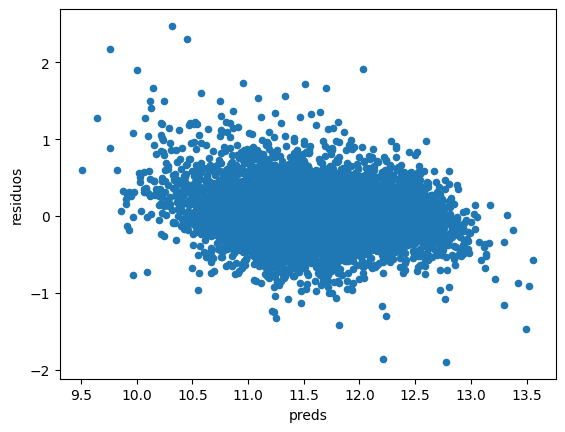

In [ ]:
# Resíduos da função SGD

plt.figure(figsize= (6.0, 6.0))

preds_sgd = pd.DataFrame({"preds":y_pred_sgd.flatten(), "verdadeiros":y_test})
preds_sgd["residuos"] = preds_sgd["verdadeiros"] - preds_sgd["preds"]
preds_sgd.plot(x = "preds", y = "residuos",kind = "scatter")
plt.show()

**Cálculo do RMSE:** Percebemos aqui que o valor da raiz quadrada do erro médio foi muito próximo ao da função Lasso, mostrando que ambos os modelos obtiveram sucessos semelhantes na previsão.

In [ ]:
# Avaliando o modelo com RMSE

from tensorflow.keras.metrics import RootMeanSquaredError

m = RootMeanSquaredError()
m.update_state(y_test, y_pred_sgd)
result_rms = m.result().numpy()

print('Root mean squared error:', result_rms)

Root mean squared error: 0.31476477


# 5. Testes dos modelos e arquivo final

Após a realização dos testes dos modelos, foi feita a combinação dos resultados de ambos para melhorar o desempenho geral das previsões. Foram atribuídos pesos diferentes às previsões dos modelos com base no desempenho individual de cada um. Apesar do RMSE ter sido semelhante para ambos os modelos, o Stochastic Gradient Descent apresentou um desempenho melhor, sendo assim, recebeu um peso maior na combinação dos resultados.

In [ ]:
# Predição em ambos modelos

lasso_predict = model_lasso.predict(X_test_final)
sgd_predict = sgd_model.predict(X_test_final).flatten()

# Média ponderada das predições de ambos modelos

preds = sgd_predict*0.6 + lasso_predict*0.4

309/309 [==============================] - 2s 6ms/step


In [ ]:
# Selecionando arquivo final

solucao = pd.DataFrame({"id":test.id, "preco":preds})
solucao['preco'] = np.exp(solucao.preco)
solucao.to_csv("/content/drive/MyDrive/Colab Notebooks/Projetos/Lighthouse 2/predicted.csv", index = False)

# 6. Considerações finais

Os modelos testados neste estudo demonstraram um desempenho satisfatório na previsão dos valores de carros com base no conjunto de dados disponível. Para melhorar ainda mais o desempenho dos modelos, seria recomendável ajustar os hiperparâmetros e realizar engenharia de recursos (feature engineering) nas variáveis independentes. Além disso, realizar treinamento com outros modelos pode seraconselhável, para que suas predições sejam combinadas com as já realizadas, com técnicas de esemble mais sofisticado.